In [1]:
import math
from collections import Counter

from qiskit import IBMQ, BasicAer
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit.quantum_info import Statevector

from typing import List, Tuple
import numpy as np
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute
from qiskit_optimization import QuadraticProgram
from qiskit.circuit.quantumregister import QuantumRegister
from qiskit.circuit.classicalregister import ClassicalRegister
from qiskit.circuit.library import GroverOperator, ZGate
from qiskit.algorithms import AmplificationProblem

from qiskit_optimization.translators import from_docplex_mp
from qiskit.circuit.library.arithmetic.adders.draper_qft_adder import DraperQFTAdder
from qiskit.algorithms import Grover
from qiskit import Aer
from qiskit.compiler import transpile, assemble

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# Register and general setup

def get_registers(bits, is_gate=False):
    qregs=[] # quantum registers
    cregs=[] # classical registers
    for i in range(bits):
        qregs.append(QuantumRegister(1, "q_grid"+str(i)))
        if not is_gate:
            cregs.append(ClassicalRegister(1, "c_grid"+str(i)))

    qregs.append(QuantumRegister(bits, "q_res")) # result qubit
    if not is_gate:
        cregs.append(ClassicalRegister(bits, "c_res")) # result qubit
        
    return qregs, cregs


def apply_h_on_address_by_key(quantum_registers, search_key):
    for reg in qregs:
        if search_key in reg.name:
            c.h(reg)

In [3]:
# Localization and grid-handling code

# def index_to_coordinate(idx, width):
#     # height (top down, zero indexed)
#     # width (left to right, zero indexed)
#     return int(idx / width), idx % width

# def is_path_dependency(top_buffer

In [18]:
# Functions for a generalized form of Dicke State Preparation

def targeted_ry(circuit, indices, params):
    for idx in range(len(indices)):
        circuit.ry(params[idx], indices[idx])
    return circuit

def targeted_cnot(circuit, index_pairs):
    for target, control in index_pairs:
        circuit.cnot(control, target)
    return circuit

def divide():
    circuit = QuantumCircuit(6)
    circuit = targeted_ry(circuit, [0, 2, 4], \
                          [2*np.arccos(np.sqrt(1/20)), \
                           np.arccos(np.sqrt(10/19)), \
                           np.arccos(np.sqrt(1/10))])
    
    circuit = targeted_cnot(circuit, [(1, 0), (2, 1)])
    circuit.ry(-np.arccos(np.sqrt(10/19)), 2)
    circuit = targeted_cnot(circuit, [(3, 2), (4, 3)])
    circuit.ry(-np.arccos(np.sqrt(1/10)), 4)
    circuit.cnot(4, 5)
    
    circuit = targeted_cnot(circuit, [(2, 1), (1, 2), (2, 1)])
    circuit = targeted_cnot(circuit, [(4, 3), (3, 4), (4, 3)])
    circuit = targeted_cnot(circuit, [(3, 2), (2, 3), (3, 2)])
    
    circuit.x(0)
    circuit.x(1)
    circuit.x(2)
    
    return circuit

def conquer():
    circuit = QuantumCircuit(6)
    circuit = targeted_ry(circuit, [1, 4], \
                          [np.pi / 2, np.pi / 2])
    circuit = targeted_cnot(circuit, [(2, 1), (3, 4)])
    circuit = targeted_ry(circuit, [1, 2, 3, 4], \
                          [np.arccos(np.sqrt(2/3)), \
                           np.arccos(np.sqrt(2/3)), \
                           np.arccos(np.sqrt(2/3)), \
                           np.arccos(np.sqrt(2/3))])
    circuit = targeted_cnot(circuit, [(2, 1), (3, 4)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [-np.pi / 2, -np.pi / 2])
    
    circuit = targeted_cnot(circuit, [(0, 1), (5, 4)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [-0.5*np.arccos(np.sqrt(2/3)), \
                           -0.5*np.arccos(np.sqrt(2/3))])
    circuit = targeted_cnot(circuit, [(1, 2), (4, 3)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [0.5*np.arccos(np.sqrt(2/3)), \
                           0.5*np.arccos(np.sqrt(2/3))])
    circuit = targeted_cnot(circuit, [(1, 0), (4, 5)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [-0.5*np.arccos(np.sqrt(2/3)), \
                           -0.5*np.arccos(np.sqrt(2/3))])
    circuit = targeted_cnot(circuit, [(1, 2), (4, 3)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [0.5*np.arccos(np.sqrt(2/3)), \
                           0.5*np.arccos(np.sqrt(2/3))])
    circuit = targeted_cnot(circuit, [(0, 1), (5, 4)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [np.pi / 2, np.pi / 2])
    circuit = targeted_cnot(circuit, [(2, 1), (3, 4)])
    circuit = targeted_ry(circuit, [1, 2, 3, 4], \
                          [np.arccos(np.sqrt(1/2)), \
                           np.arccos(np.sqrt(1/2)), \
                           np.arccos(np.sqrt(1/2)), \
                           np.arccos(np.sqrt(1/2))])
    circuit = targeted_cnot(circuit, [(2, 1), (3, 4)])
    circuit = targeted_ry(circuit, [1, 4], \
                          [-np.pi / 2, -np.pi / 2])
    
    return circuit

In [19]:
#circuit = QuantumCircuit(6, 6)
#circuit = divide(circuit)
#circuit = conquer(circuit)
#circuit.measure(range(0, 6), range(0, 6))
#circuit.draw()

In [21]:
def add(circuit, num_bits, qreg1, qreg2):
    draper_circ = DraperQFTAdder(num_bits)
    return circuit.compose(draper_circ, list(qreg1) + list(qreg2))

def to_bin(val, num_bits):
    bin_val = bin(val)[2:]
    # do some padding
    bin_val = "0"*(num_bits-len(bin_val))+bin_val
    return bin_val

def set_values(qc, num_bits, val, ctrl, qreg):
    bin_val = to_bin(val, num_bits)
    for j, bin_digit in enumerate(bin_val):
        if bin_digit == "1":
            qc.cx(ctrl,qreg[num_bits-j-1])
    return qc

# add 1 if dir_qubit = |R>, n if dir_qubit = |D>
def add_based_on_dir_qubit(num_bits, n):
    idx_offset_qreg = QuantumRegister(num_bits, "idx_offset")
    curr_idx_qreg = QuantumRegister(num_bits, "curr_idx")
    dir_q = QuantumRegister(1)
    qc = QuantumCircuit(idx_offset_qreg, curr_idx_qreg, dir_q)
                            
    qc.cx(dir_q, idx_offset_qreg[0], ctrl_state=0) # R just sets it to 1
    qc = set_values(qc, num_bits, n, dir_q, idx_offset_qreg)
        
    qc = add(qc, num_bits, idx_offset_qreg, curr_idx_qreg)
    
    qc.cx(dir_q, idx_offset_qreg[0], ctrl_state=0) # R just sets it to 1
    qc = set_values(qc, num_bits, n, dir_q, idx_offset_qreg)

    return qc

def path_set_based_on_current_index(num_bits, n, qregs):
    qc = QuantumCircuit(*qregs)
    
    for i in range(1, n*n):
        bin_val = to_bin(i, num_bits)
        for j, bin_digit in enumerate(bin_val):
            if bin_digit == "0":
                qc.x(curr_idx_qreg[num_bits-j-1])
        qc.mcx(curr_idx_qreg, path_grid_qreg[i])
        for j, bin_digit in enumerate(bin_val):
            if bin_digit == "0":
                qc.x(curr_idx_qreg[num_bits-j-1])
    return qc
                
n = 4
# we subtract by 1 because 4=100, doesnt exist we just need 0,1,2,3
num_bits = len(bin(n*n - 1)) - 2
idx_offset_qreg = QuantumRegister(num_bits, "idx_offset")
curr_idx_qreg = QuantumRegister(num_bits, "curr_idx")
path_grid_qreg = QuantumRegister(n*n, "grid")
dir_seq_qreg = QuantumRegister(2*n-2, "dir_seq")
extra_grid_qreg = QuantumRegister(2, "extra_grid")
qregs = [dir_seq_qreg, idx_offset_qreg, curr_idx_qreg, extra_grid_qreg, path_grid_qreg]
cregs = [ClassicalRegister(n*n, "m_grid")]
qc = QuantumCircuit(*qregs, *cregs)
divide_gate = divide().to_gate()
divide_gate.label = "divide"
qc.append(divide_gate, list(dir_seq_qreg))
conquer_gate = conquer().to_gate()
conquer_gate.label = "conquer"
qc.append(conquer_gate, list(dir_seq_qreg))

qc.x(path_grid_qreg[0]) # always set grids[0] to 1

for dir_q in dir_seq_qreg:
    # based on input direction, change the index offset
    # R (i.e ctrl_state=0): should +1
    # D (i.e ctrl_state=1): should +n
    # [idx_offset_qreg, curr_idx_qreg, dir_q]
    add_gate = add_based_on_dir_qubit(num_bits, n).to_gate()
    add_gate.label = "add"
    qc.append(add_gate, list(idx_offset_qreg)+list(curr_idx_qreg)+[dir_q])

    path_set_gate = path_set_based_on_current_index(num_bits, n, [curr_idx_qreg, path_grid_qreg] ).to_gate()
    path_set_gate.label = "path_set_gate"
    qc.append(path_set_gate, list(curr_idx_qreg) + list(path_grid_qreg))

for dir_q in qregs[0]:
    inverse_add_gate = add_gate.inverse()
    inverse_add_gate.label = "inverse_add_gate"
    qc.append(inverse_add_gate, list(idx_offset_qreg)+list(curr_idx_qreg)+[dir_q])

qc.append(conquer_gate.inverse(), list(dir_seq_qreg))
qc.append(divide_gate.inverse(), list(dir_seq_qreg))
#qc.barrier()
#qc.measure(curr_idx_qreg, cregs[0])
#qc.barrier()
#qc.measure(path_grid_qreg, cregs[1])
#qc.draw('mpl')

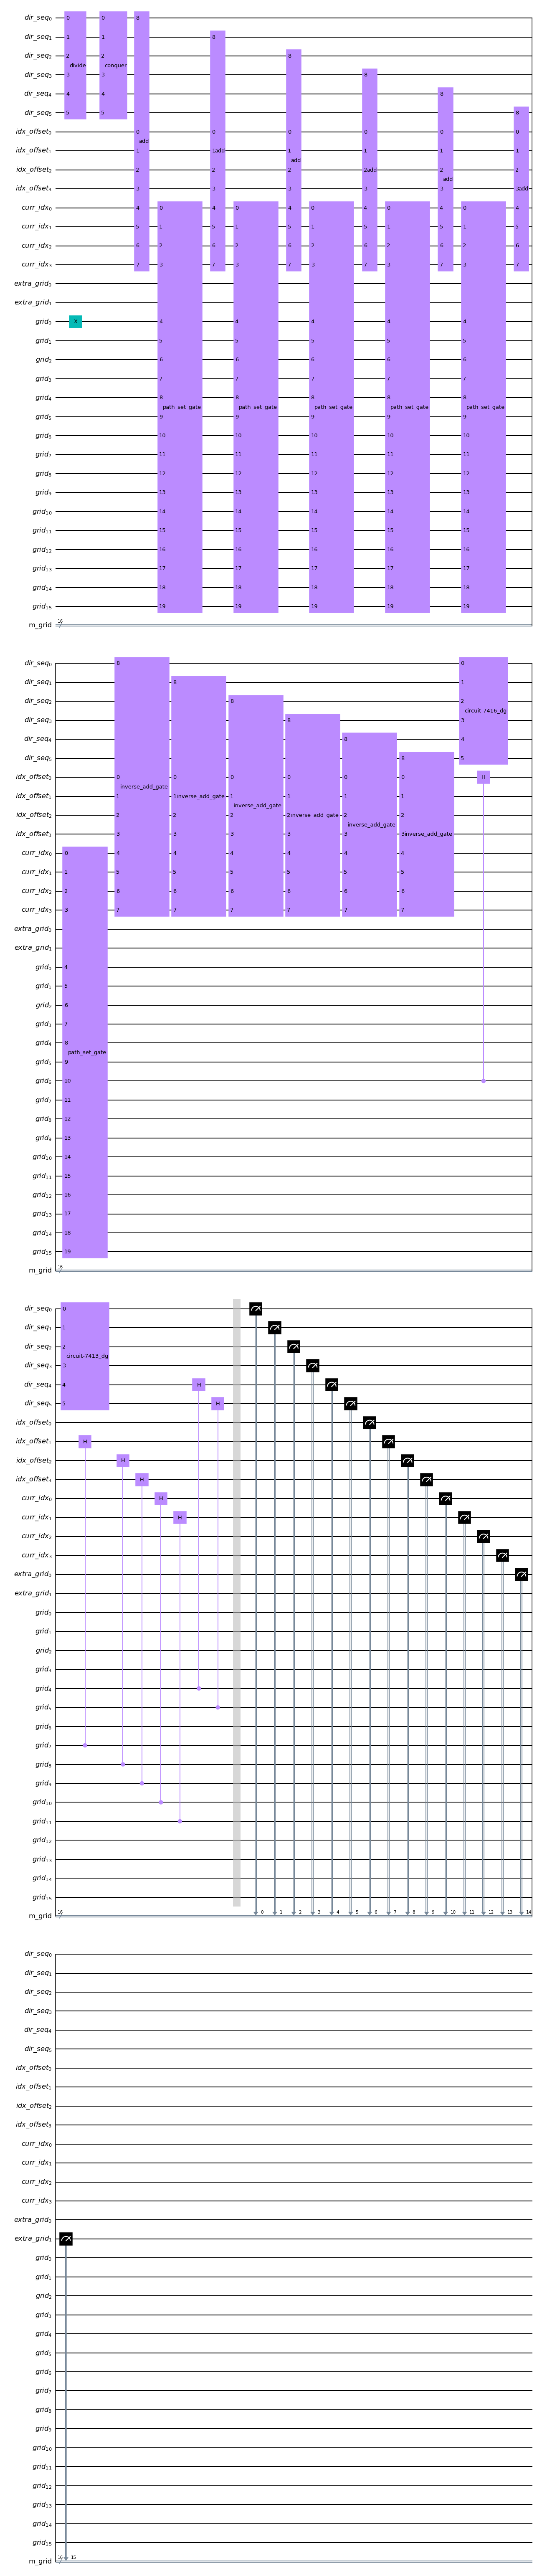

In [22]:
maze = [0,0,0,0, 0.5,0.5,0.5,0.5, 0.5,0.5,0.5,0.5, 0,0,0,0]
#shortest_paths = [1,1,0,1] #[[1,1,1,0], [1,1,0,1]]
# output should be [1,1,1,0] with prob half

# set the maze based on the paths
for i in range(len(maze)):
    if maze[i] == 0:
        pass
    elif maze[i] == 0.5:
        qc.ch(i + 16, i)
    elif maze[i] == 1:
        qc.cx(i + 16, i)
    else:
        qc.crx(2*math.acos(math.sqrt(maze[i])), i + 16, i)
qc.barrier()
qc.measure(range(0, 16),range(0, 16))
qc.draw('mpl')

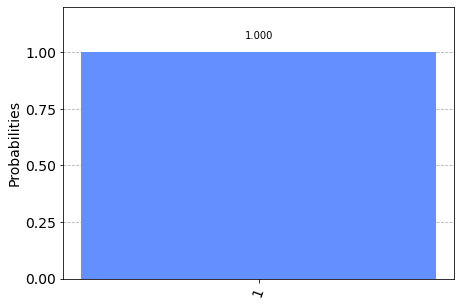

In [17]:
qr = QuantumCircuit(2, 1)
qr.x(0)
qr.crx(2*math.acos(math.sqrt(0)), 0, 1)
qr.measure(1, 0)

# Execute and see results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qr = transpile(qr, aer_sim)
qobj = assemble(transpiled_qr)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)


[('0000001000010001', 1), ('0000000000110011', 1), ('0000000000110111', 1), ('0000010000011111', 1), ('0000010000100010', 1), ('0000000001110011', 1), ('0000100000011100', 1), ('0000100100111000', 1), ('0000110000111001', 1), ('0000000011110110', 1)]


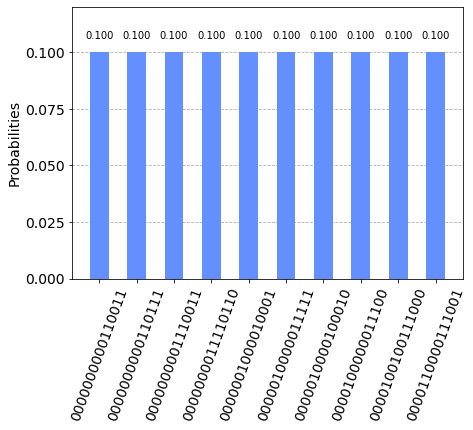

In [23]:
backend = provider.backends.ibmq_qasm_simulator
#backend = BasicAer.get_backend('ibmq_qasm_simulator')
shots = 10
results = execute(qc, backend=backend, shots=shots).result()
answer = results.get_counts()

print(Counter(answer).most_common())
# print(answer)
plot_histogram(answer)

#[('0000 1000 1100 0111 0001', 3), ('0000 1100 0111 0001 0001', 3), ('0000 1000 1100 0100 0111', 2), ('0000 11000 1000 110 0011', 1), ('0000 1110 0010 0011 0001', 1)]

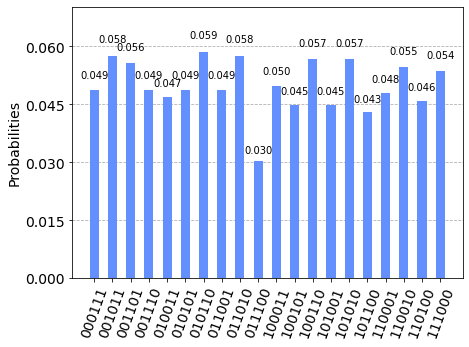

In [34]:
# Execute and see results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(circuit, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)

[('010011', 3396), ('100110', 3355), ('001110', 3347), ('101100', 3345), ('001011', 3333), ('110010', 3329), ('111000', 3306), ('100011', 3289), ('101010', 3286), ('110001', 3281), ('100101', 3265), ('010101', 3261), ('011010', 3260), ('110100', 3259), ('010110', 3250), ('000111', 3225), ('101001', 3213), ('011001', 3201), ('011100', 3183), ('001101', 3152)]


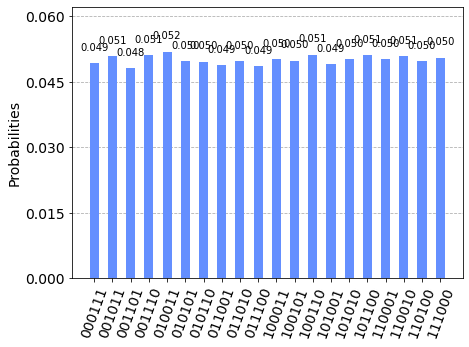

In [45]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 65536
results = execute(circuit, backend=backend, shots=shots).result()
answer = results.get_counts()

print(Counter(answer).most_common())
# print(answer)
plot_histogram(answer)